# Table of Contents
 <p><div class="lev1"><a href="#Load-data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></div><div class="lev1"><a href="#Plot-pairing"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot pairing</a></div><div class="lev2"><a href="#Example-plot"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example plot</a></div><div class="lev2"><a href="#Batch-plot"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Batch plot</a></div><div class="lev1"><a href="#Pairing-vs-compartment-vs-expression"><span class="toc-item-num">3&nbsp;&nbsp;</span>Pairing vs compartment vs expression</a></div><div class="lev2"><a href="#Basic-histograms"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Basic histograms</a></div><div class="lev1"><a href="#Pairing-in-SLMB"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pairing in SLMB</a></div><div class="lev1"><a href="#Pairing-scores-vs-insulation-scores"><span class="toc-item-num">5&nbsp;&nbsp;</span>Pairing scores vs insulation scores</a></div>

In [1]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import seaborn.apionly as sns
mpl.style.use('seaborn-talk')
pal = sns.palettes.get_color_cycle()

import numpy as np
import pandas as pd
import scipy.stats as st

import cooler
import bioframe

import cooltools
import cooltools.num.numutils

In [2]:
# add fall colormap
import matplotlib

def listToColormap(colorList, cmapName=None):
    colorList = np.array(colorList)
    if colorList.min() < 0:
        raise ValueError("Colors should be 0 to 1, or 0 to 255")
    if colorList.max() > 1.:
        if colorList.max() > 255:
            raise ValueError("Colors should be 0 to 1 or 0 to 255")
        else:
            colorList = colorList / 255.
    return matplotlib.colors.LinearSegmentedColormap.from_list(cmapName, colorList, 256)

fallList = [
     (255, 255, 255), (255, 255, 204),
     (255, 237, 160), (254, 217, 118),
     (254, 178, 76), (253, 141, 60),
     (252, 78, 42), (227, 26, 28),
     (189, 0, 38), (128, 0, 38), (0, 0, 0)]


def registerList(mylist, name):
    mymap = listToColormap(mylist, name)
    mymapR = listToColormap(mylist[::-1], name + "_r")
    mymapR.set_bad('white',1.)
    mymap.set_bad('white',1.)
    matplotlib.cm.register_cmap(name, mymap)
    matplotlib.cm.register_cmap(name + "_r", mymapR)

registerList(fallList, "fall")

coolwarm = matplotlib.cm.coolwarm
coolwarm.set_bad('white',1.)
matplotlib.cm.register_cmap('coolwarm', coolwarm)

def select_finite(z):
    return z[np.isfinite(z)]

def gridspec_inches(
    wcols,
    hrows,
    fig_kwargs={}):

    import matplotlib as mpl
    import matplotlib.pyplot as plt

    fig_height_inches = (
        sum(hrows)
        )

    fig_width_inches = (
        sum(wcols)
        )

    fig=plt.figure(
        figsize=(fig_width_inches,fig_height_inches),
        subplotpars=mpl.figure.SubplotParams(
        left=0,
        right=1,
        bottom=0,
        top=1,
        wspace =0,
        hspace = 0.0),
        frameon=False,
        **fig_kwargs)
    fig.set_size_inches(fig_width_inches,fig_height_inches,forward=True)

    gs = mpl.gridspec.GridSpec(
        len(hrows),
        len(wcols),
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=0,
        hspace=0,
        width_ratios=wcols,
        height_ratios=hrows
        )

    return fig, gs


# Load data

In [3]:
dm3_chromsizes = bioframe.read_chromsizes(
    '/net/levsha/share/lab/genomes/dm3/dm3.chrom.sizes.higlass',
    all_names=True)


dm3_057_439_chromsizes = bioframe.read_chromsizes(
    '/net/levsha/share/lab/genomes/phased/dm3-057-439-JJ-snps-hybrid/dm3_057_439-JJ-snps-hybrid.chromsizes',
    all_names=True)

In [4]:
RES = 4000
pairing = pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/pairing-057-439/tables/JJ17_18.log2_pairing.res_4000.win_24000.balance.nonorm.per_hom.nanmean.tsv',
#     skiprows=1,
#     header=None,
#     names=['chrom','start', 'end', 'pairing']
    comment='#'
    
)
eigs= pd.read_table(
    '/net/levsha/share/lab/DrosophilaWulab/tracks/eigs/dm3/JJ17_18.ciseigs.{}.clip_99.genedens_sort.tsv'.format(RES)
)
c = cooler.Cooler('/net/levsha/share/lab/DrosophilaWulab/coolers/JJ17_18.wo3kbCisTransHom.{}.cool'.format(RES),mode='r')

# Plot pairing

In [13]:
def plot_pairing(reg_ref):
    reg_057 = reg_ref.replace(':','_057:',)
    reg_439 = reg_ref.replace(':','_439:',)

    chrom, start, end = bioframe.parse_region_string(reg_ref)

    mat_cis_057 = c.matrix().fetch(reg_057, reg_057)
    mat_cis_439 = c.matrix().fetch(reg_439, reg_439)
    mat_cis = (mat_cis_057 + mat_cis_439) / 2
    mat_trans = c.matrix().fetch(reg_057, reg_439)
    loc_pairing_057 = bioframe.slice_bedframe(pairing, (chrom+'_057', start, end))
    loc_pairing_439 = bioframe.slice_bedframe(pairing, (chrom+'_439', start, end))

    
    loc_eigs = bioframe.slice_bedframe(eigs, (chrom, start, end))

    # ins = ins_table['log2_insulation_score_20000']
    # boundary_mids = ((ins_table.start+ins_table.end)/2)[ins_table.boundary_strength_20000 > MIN_BOUNDARY_STRENGTH]

    
    loc_expr_plus = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.plus.all.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )

    loc_expr_minus = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/rnaseq/dm3/RNA__cells_jjwu2017.minus.all.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )


    H3K27ac = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K27ac_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.fc.signal.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )
    
    H3K27me3 = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K27me3__Kc167__CubenasPottsCorces2017__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017.fc.signal.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )
    
    Pc_RJ = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__Pc_RJ_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )
    
        
    RnaPolII = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__RNAPII_NT__Kc167__LiCorces2015__VS__ChIP__IgG_NT__Kc167__LiCorces2015.fc.signal.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )
    
    H3K4me1 = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K4me1_Kc__Kc167__LiCorces2015__VS__ChIP__Input_20HE_0hrs__Kc167__WoodCorces2011.fc.signal.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )
    
    H3K4me3 = bioframe.read_bigwig_binned(
        '/net/levsha/share/lab/DrosophilaWulab/tracks/chip/bigwig/dm3/ChIP__H3K4me3_NT__Kc167__LiCorces2015__VS__ChIP__Histone3__Kc167__CubenasPottsCorces2017.fc.signal.bw',
        chrom,
        start,
        end,
        (end-start)//1000
    )

    




    fig, gs = gridspec_inches(wcols=[8,0.5], hrows=[8,0.2,8,0.2,1,0.2,1,0.2,1,0.2,1,0.2,1,0.2,1,0.2,1,0.2,1])
    plt.subplot(gs[0,0])
    hm=plt.imshow(
        np.log10(mat_cis),
        vmin=-3.5,
        vmax=-2.0,
        cmap='fall',
        extent=[start, end, end, start]
    )
    # for b in boundaries:
    #     plt.axvline(b, ls='--',lw=0.5, color='k')
    plt.xticks(plt.xticks()[0],[])
    plt.ylabel(chrom + ' pos, bp')


    plt.subplot(gs[0,1])
    plt.axis('off')
    cb = plt.colorbar(hm,label='log10 IC CF')
    #cb.set_ticks([-0.5,0,0.5])

    plt.subplot(gs[2,0])
    hm=plt.imshow(
        np.log10(mat_trans),
        vmin=-3.5,
        vmax=-2.0,
        cmap='fall',
        extent=[start,end,end,start]
    )
    # for b in boundaries:
    #     plt.axvline(b, ls='--',lw=0.5, color='k')
    plt.xticks(plt.xticks()[0],[])
    plt.ylabel(chrom + ' pos, bp')


    plt.subplot(gs[2,1])
    plt.axis('off')
    cb = plt.colorbar(hm,label='log10 IC CF')
    #cb.set_ticks([-0.5,0,0.5])



    plt.subplot(gs[4,0])
    xs = np.linspace(start,end, loc_pairing_057.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        loc_pairing_057.pairing,
        lw=2,
        #alpha=0.85
    )
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        loc_pairing_057.cis_norm,
        lw=2,
        #alpha=0.85
    )
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        loc_pairing_439.cis_norm,
        lw=2,
        c='r',
        #alpha=0.85
    )

    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])
    plt.ylim(-9, -6)
    plt.ylabel('pairing score')
    plt.axhline(0, ls='--', lw=0.5)




    plt.subplot(gs[6,0])
    xs = np.linspace(start,end, loc_eigs.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        loc_eigs.E1,
        lw=2,
        #alpha=0.85
    )
    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])

    plt.ylabel('E1')
    plt.ylim(-1, 1.5)
    plt.axhline(0, ls='--', lw=0.5)


    # ax2 = plt.gca().twinx()

    # plt.plot(
    #     xs,
    #     #cooltools.num.numutils.normalize_score(band_score_inside_masked),
    #     loc_eigs.GC,
    #     lw=1,
    #     c='red'
    #     #alpha=0.85
    # )
    # plt.xlim(xs[0], xs[-1])
    # plt.xticks(plt.xticks()[0],[])

    # plt.ylabel('GC')



    plt.subplot(gs[8,0])
    xs = np.linspace(start,end, loc_expr_plus.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        loc_expr_plus,
        lw=2,
        #alpha=0.85
    )
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        -loc_expr_minus,
        lw=2,
        #alpha=0.85
    )

    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])

    plt.ylim(-5, 5)
    plt.ylabel('expression')
    #plt.axhline(0, ls='--', lw=0.5)

    plt.subplot(gs[10,0])
    xs = np.linspace(start,end, H3K27me3.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        #np.log10(H3K27ac),
        H3K27me3,
        lw=2,
        #alpha=0.85
    )
    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])

    plt.ylim(0, 3)
    plt.ylabel('H3K27me3')



    plt.subplot(gs[12,0])
    xs = np.linspace(start,end, H3K27ac.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        #np.log10(H3K27ac),
        Pc_RJ,
        lw=2,
        #alpha=0.85
    )
    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])

    # plt.ylim(-5, 5)
    plt.ylabel('Pc RJ')

    plt.subplot(gs[14,0])
    xs = np.linspace(start,end, RnaPolII.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        #np.log10(H3K27ac),
        RnaPolII,
        lw=2,
        #alpha=0.85
    )
    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])

    # plt.ylim(-5, 5)
    plt.ylabel('RNA PolII')
    
    plt.subplot(gs[16,0])
    xs = np.linspace(start,end, H3K27ac.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        #np.log10(H3K27ac),
        H3K27ac,
        lw=2,
        #alpha=0.85
    )
    plt.xlim(xs[0], xs[-1])
    plt.xticks(plt.xticks()[0],[])

    # plt.ylim(-5, 5)
    plt.ylabel('H3K27ac')

    plt.subplot(gs[18,0])
    xs = np.linspace(start,end, H3K4me3.shape[0])
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        #np.log10(H3K4me3),
        H3K4me1,
        lw=1,
        #alpha=0.85
    )

    plt.xlim(xs[0], xs[-1])
    plt.ylabel('H3K4me1')
    plt.xlabel(chrom + ' pos, bp')

    plt.gca().twinx()
    plt.plot(
        xs,
        #cooltools.num.numutils.normalize_score(band_score_inside_masked),
        #np.log10(H3K4me3),
        H3K4me3,
        lw=1,
        c='red'
        #alpha=0.85
    )

    plt.xlim(xs[0], xs[-1])
    plt.ylabel('H3K4me3')


## Example plot

/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in log10
/home/golobor/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in log10


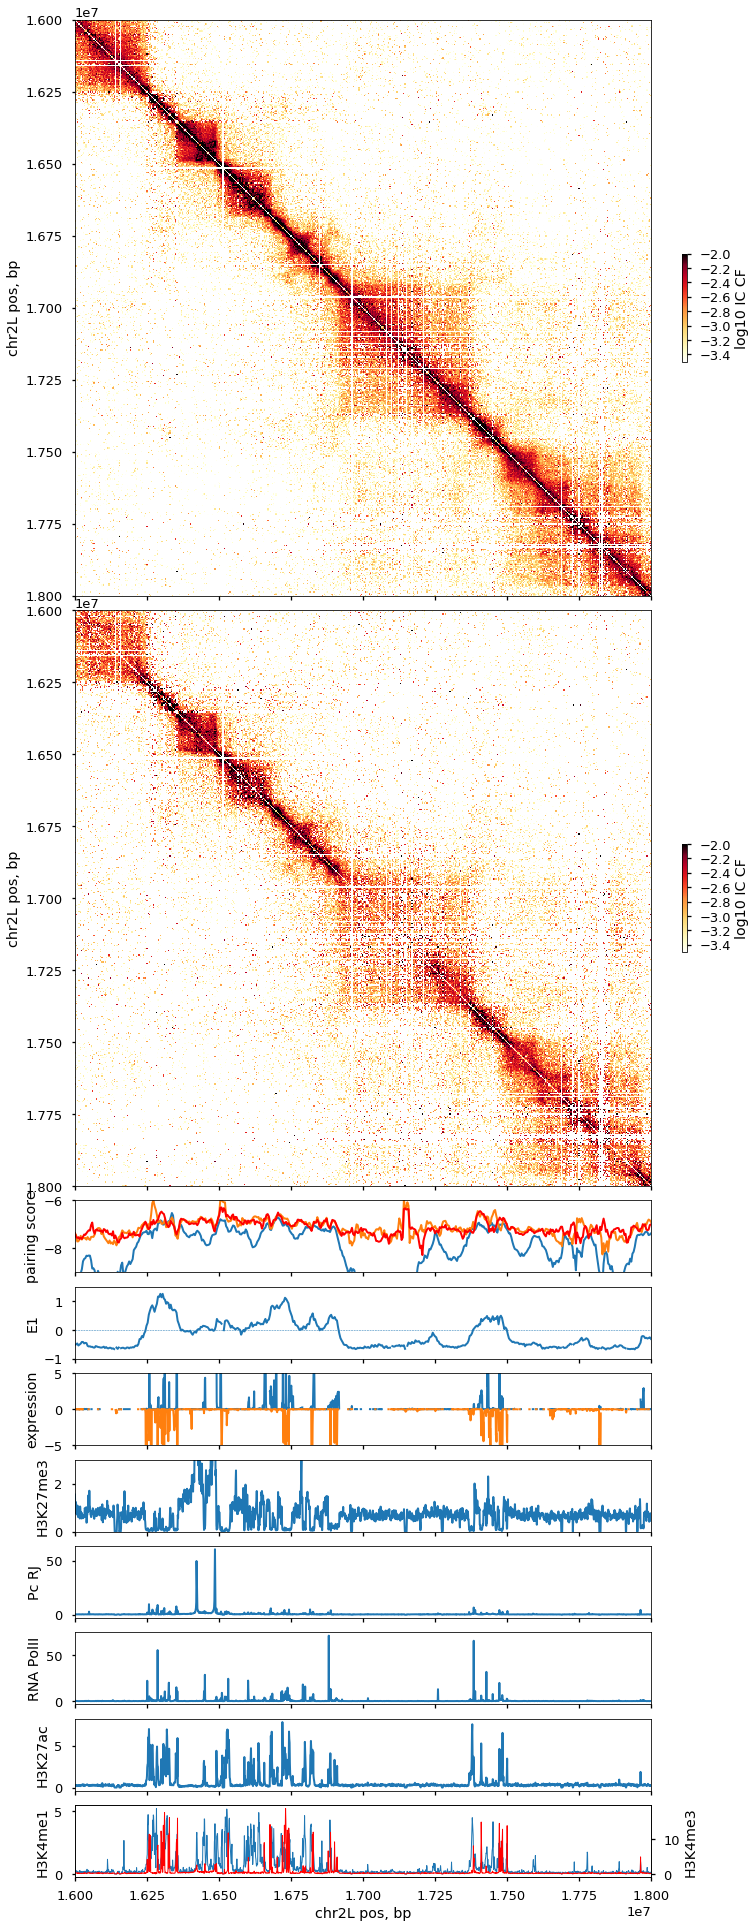

In [14]:
REG_REF = 'chr2L:16,000,000-18,000,000'
plot_pairing(REG_REF)

## Batch plot

In [10]:
FIG_FOLDER = './define/your/folder'

for chrom in ['chr2L','chr2R','chr3R','chr3L',]:
    for start in 2000000 * np.arange(dm3_chromsizes[chrom]//2000000):
        end = start+2000000
        REG_REF = '{}:{}-{}'.format(chrom, start,end)

        plot_pairing(REG_REF)
        
        for fmt in ['.png','.pdf']:
            plt.savefig(
                FIG_FOLDER + chrom +'-' + str(start//1000000) +'-' + str(end//1000000) +'Mb'  + fmt,
                dpi=300,
                bbox_inches = 'tight')
        plt.close()
